In [2]:
%matplotlib inline
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


##Model background
Here is an example based on the model of Freyberg, 1988.  The synthetic model is a 2-dimensional MODFLOW model (X-Z domain) with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  THe calibration period uses the recharge and well flux of Freyberg, 1988; the last stress period use 25% less recharge and 25% more pumping.

The inverse problem has 761 parameters: hydraulic conductivity of each active model cell, calibration and forecast period recharge multipliers, storage and specific yeild, well flux for each of the six wells, and river bed conductance for each river-type boundary.  The inverse problem has 13 head obseravtions, measured at the end of the steady-state calibration period.  The forecasts of interest include the sw-gw exchange flux during both stress periods, the water level in well cell at row 28 column 5 at the end of the stress periods.  The forecasts are included in the Jacobian matrix as zero-weight observations. The model files, pest control file and previously-calculated jacobian matrix are in the `freyberg/` folder


Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

  ...load method not completed. default nwt file created.


<function matplotlib.pyplot.show>

/Users/jwhite/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


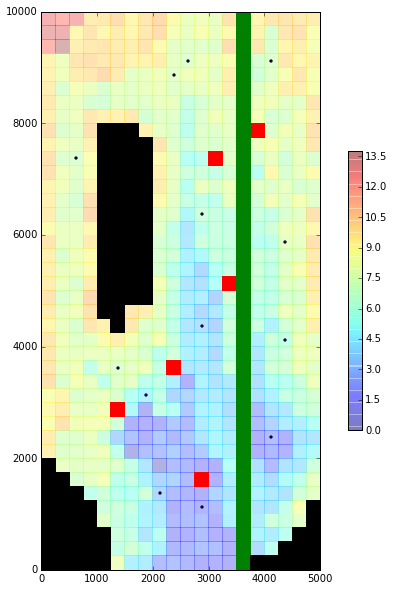

In [4]:

import flopy

# load the model
model_ws = os.path.join("Freyberg","extra_crispy")
ml = flopy.modflow.Modflow.load("freyberg",model_ws=model_ws)

# plot some model attributes
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111,aspect="equal")
ml.upw.hk.plot(axes=[ax],colorbar=True,alpha=0.3)
ml.wel.stress_period_data.plot(axes=[ax])
ml.riv.stress_period_data.plot(axes=[ax])

# plot obs locations
obs = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
obs_x = [ml.dis.sr.xcentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
obs_y = [ml.dis.sr.ycentergrid[r-1,c-1] for r,c in obs.loc[:,["row","col"]].values]
ax.scatter(obs_x,obs_y,marker='.')


plt.show


##Using `pyemu`

In [5]:
import pyemu

First create a linear_analysis object.  We will use `ErrVar`  derived type, which replicates the behavior of the `PREDVAR` suite of PEST as well as `ident_par` utility.  We pass it the name of the jacobian matrix file.  Since we don't pass an explicit argument for `parcov` or `obscov`, `pyemu` attempts to build them from the parameter bounds and observation weights in a pest control file (.pst) with the same base case name as the jacobian.  Since we are interested in forecast uncertainty as well as parameter uncertainty, we also pass the names of the forecast sensitivity vectors we are interested in, which are stored in the jacobian as well.  Note that the `forecasts` argument can be a mixed list of observation names, other jacobian files or PEST-compatible ASCII matrix files.  Remember you can pass a filename to the `verbose` argument to write log file.

Since most groundwater model history-matching analyses focus on adjusting hetergeneous hydraulic properties and not boundary condition elements, let's identify the well flux and recharge parameters as `omitted` in the error variance analysis.  We can conceptually think of this action as excluding these parameters from the history-matching process. Later we will explicitly calculate the penalty for not adjusting these parameters.

In [15]:
# get the list of forecast names from the pest++ argument in the pest control file
jco = os.path.join("freyberg","freyberg.jcb")
pst = pyemu.Pst(jco.replace("jcb","pst"))
omitted = [pname for pname in pst.par_names if pname.startswith("wf") or pname.startswith("rch")]
forecasts = pst.pestpp_options["forecasts"].split(',')
la = pyemu.ErrVar(jco=jco, forecasts=forecasts,verbose=True,omitted_parameters=omitted)
print(la.jco.shape)

2015-11-27 13:58:41.542764 starting: pre-loading base components

2015-11-27 13:58:41.542830 starting: loading jco: freyberg/freyberg.jcb

2015-11-27 13:58:41.577410 finished: loading jco: freyberg/freyberg.jcb took: 0:00:00.034580

2015-11-27 13:58:41.577460 starting: loading pst: freyberg/freyberg.pst

2015-11-27 13:58:41.625090 finished: loading pst: freyberg/freyberg.pst took: 0:00:00.047630

2015-11-27 13:58:41.625434 starting: loading parcov

2015-11-27 13:58:41.717953 finished: loading parcov took: 0:00:00.092519

2015-11-27 13:58:41.718311 starting: loading obscov

2015-11-27 13:58:41.852894 finished: loading obscov took: 0:00:00.134583

2015-11-27 13:58:41.853245 starting: loading forecasts

2015-11-27 13:58:41.876900 finished: loading forecasts took: 0:00:00.023655

2015-11-27 13:58:41.876946 finished: pre-loading base components took: 0:00:00.334182

2015-11-27 13:58:41.876960 starting: dropping prior information

2015-11-27 13:58:41.877864 starting: removing 761 prior info 

#Parameter identifiability
The `errvar` dervied type exposes a method to get a `pandas` dataframe of parameter identifiability information.  Recall that parameter identifiability is expressed as $d_i = \Sigma(\mathbf{V}_{1i})^2$, where $d_i$ is the parameter identifiability, which ranges from 0 (not identified by the data) to 1 (full identified by the data), and $\mathbf{V}_1$ are the right singular vectors corresonding to non-(numerically) zero singular values.  First let's look at the singular spectrum of $\mathbf{Q}^{\frac{1}{2}}\mathbf{J}$, where $\mathbf{Q}$ is the cofactor matrix and $\mathbf{J}$ is the jacobian:

In [8]:
s = la.qhalfx.s

2015-11-27 13:57:25.840201 starting: qhalfx

2015-11-27 13:57:25.840275 starting: qhalf

2015-11-27 13:57:25.843797 finished: qhalf took: 0:00:00.003522

2015-11-27 13:57:25.861463 finished: qhalfx took: 0:00:00.021262



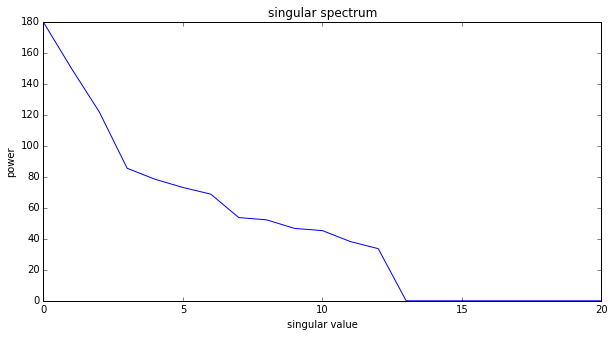

In [9]:
import pylab as plt
figure = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.plot(s.x)
ax.set_title("singular spectrum")
ax.set_ylabel("power")
ax.set_xlabel("singular value")
ax.set_xlim(0,20)
plt.show()

We see that the singluar spectrum decays rapidly (not uncommon) and that we can really only support about 13 right singular vectors even though we have 700+ parameters in the inverse problem.  

Let's get the identifiability dataframe at 13 singular vectors:

In [10]:
ident_df = la.get_identifiability_dataframe(13) # the method is passed the number of singular vectors to include in V_1
ident_df.sort("ident",ascending=False).iloc[0:10]

2015-11-27 13:57:52.043463 starting: xtqx

2015-11-27 13:57:52.109870 finished: xtqx took: 0:00:00.066407



,right_sing_vec_1,right_sing_vec_2,right_sing_vec_3,right_sing_vec_4,right_sing_vec_5,right_sing_vec_6,right_sing_vec_7,right_sing_vec_8,right_sing_vec_9,right_sing_vec_10,right_sing_vec_11,right_sing_vec_12,right_sing_vec_13,ident
hkr30c15,3.290900e-07,7.044375e-06,2.479020e-06,1.140011e-04,5.082595e-06,4.144797e-04,2.914886e-05,0.000325,0.157959,1.404472e-04,0.143139,1.370276e-02,1.826426e-04,0.316021
hkr03c11,5.003303e-02,1.404578e-02,1.739226e-02,2.993984e-05,4.063808e-05,1.548729e-06,7.199231e-09,0.000181,0.000013,1.845528e-01,0.000079,4.467137e-05,7.423482e-04,0.267156
hkr34c09,7.345083e-04,9.125997e-03,1.716865e-03,7.862148e-02,1.256701e-01,2.240252e-02,1.716067e-02,0.000011,0.000034,1.218779e-05,0.000035,3.552695e-06,5.335394e-08,0.255528
hkr04c10,6.392467e-02,1.736472e-02,1.887143e-02,3.450696e-05,6.174547e-05,1.370228e-06,1.016931e-04,0.002219,0.000054,1.491807e-01,0.000036,9.585028e-06,2.037913e-05,0.251880
hkr22c12,7.338922e-04,7.121903e-03,2.094718e-03,2.357636e-02,8.307662e-02,1.218885e-03,7.865360e-02,0.024846,0.001072,4.587448e-05,0.000250,7.825051e-04,3.000407e-05,0.223503
hkr25c06,6.255760e-03,3.622798e-02,8.721402e-04,1.046226e-01,1.543280e-02,1.869279e-03,5.109957e-02,0.000181,0.000003,2.053997e-06,0.000002,6.854118e-07,3.246756e-07,0.216569
hkr35c12,1.611155e-04,1.577611e-03,2.415478e-04,8.132104e-03,4.097179e-04,1.943214e-01,7.026843e-05,0.000066,0.001226,2.254672e-06,0.000595,3.565904e-05,7.077702e-07,0.206839
hkr35c10,8.196639e-05,1.008543e-03,1.565779e-04,3.927183e-03,1.947728e-02,1.588248e-01,3.140667e-03,0.000001,0.000499,3.390147e-07,0.000237,1.067324e-05,1.649054e-07,0.187366
hkr04c16,1.876654e-07,9.328463e-08,2.221951e-07,2.703059e-12,1.173842e-08,1.221827e-09,1.348791e-07,0.000006,0.000047,7.769099e-05,0.000595,1.033121e-02,1.672190e-01,0.178277
hkr03c15,1.888557e-07,9.070880e-08,2.262869e-07,6.054070e-10,2.804157e-08,1.102138e-09,2.113285e-07,0.000009,0.000068,7.629373e-05,0.000746,1.121317e-02,1.657981e-01,0.177912


Plot the indentifiability:

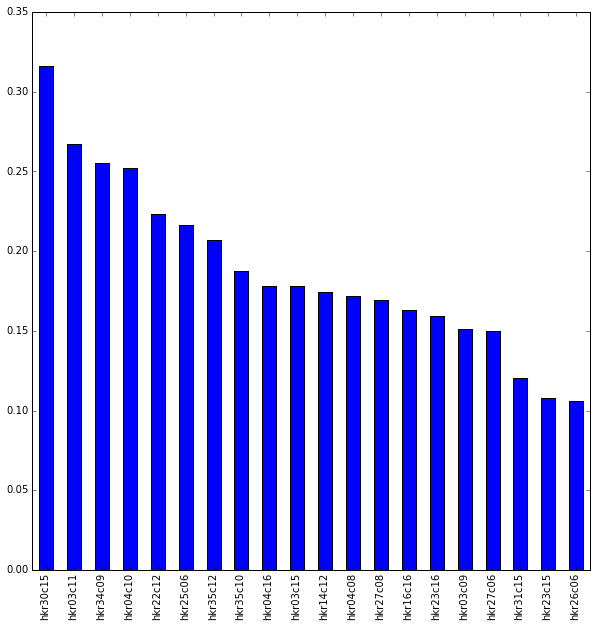

In [11]:
ident_df.sort("ident",ascending=False).iloc[0:20].loc[:,"ident"].plot(kind="bar",figsize=(10,10))

#Forecast error variance 

Now let's explore the error variance of the forecasts we are interested in.  We will use an extended version of the forecast error variance equation:   

$\sigma_{s - \hat{s}}^2 = \underbrace{\textbf{y}_i^T({\bf{I}} - {\textbf{R}})\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_i}({\textbf{I}} - {\textbf{R}})^T\textbf{y}_i}_{1} + \underbrace{{\textbf{y}}_i^T{\bf{G}}\boldsymbol{\Sigma}_{\mathbf{\epsilon}}{\textbf{G}}^T{\textbf{y}}_i}_{2} + \underbrace{{\bf{p}}\boldsymbol{\Sigma}_{{\boldsymbol{\theta}}_o}{\bf{p}}^T}_{3}$

Where term 1 is the null-space contribution, term 2 is the solution space contribution and term 3 is the model error term (the penalty for not adjusting uncertain parameters).  Remember the well flux and recharge parameters that we marked as omitted?  The consequences of that action can now be explicitly evaluated.  See Moore and Doherty (2005) and White and other (2014) for more explanation of these terms.  Note that if you don't have any `omitted_parameters`, the only terms 1 and 2 contribute to error variance

First we need to create a list (or numpy ndarray) of the singular values we want to test.  Since we have $\lt13$ data, we only need to test up to $13$ singular values because that is where the action is:

In [12]:
sing_vals = np.arange(14)

The `ErrVar` derived type exposes a convience method to get a multi-index pandas dataframe with each of the terms of the error variance equation:

In [13]:
errvar_df = la.get_errvar_dataframe(sing_vals)
errvar_df.iloc[0:10]

2015-11-27 13:58:04.354059 starting: calc first term parameter @0

2015-11-27 13:58:04.383258 finished: calc first term parameter @0 took: 0:00:00.029199

2015-11-27 13:58:04.383375 starting: calc second term prediction @0

2015-11-27 13:58:04.440416 finished: calc second term prediction @0 took: 0:00:00.057041

2015-11-27 13:58:04.440896 starting: calc third term prediction @0

2015-11-27 13:58:04.448380 finished: calc third term prediction @0 took: 0:00:00.007484

2015-11-27 13:58:04.448450 starting: calc first term parameter @1

2015-11-27 13:58:04.477895 finished: calc first term parameter @1 took: 0:00:00.029445

2015-11-27 13:58:04.478201 starting: calc second term prediction @1

2015-11-27 13:58:04.478989 starting: calc G @1

2015-11-27 13:58:04.540217 finished: calc G @1 took: 0:00:00.061228

2015-11-27 13:58:04.593956 finished: calc second term prediction @1 took: 0:00:00.115755

2015-11-27 13:58:04.594921 starting: calc third term prediction @1

2015-11-27 13:58:04.602147 fin

first                                         second            \
  or28c05_0 or28c05_1      sw_gw_0       sw_gw_1 or28c05_0 or28c05_1   
0  0.303632  0.744522  2346.665821  93125.784926  0.000000  0.000000   
1  0.273260  0.728780  2303.549610  93110.827506  0.000004  0.000002   
2  0.120244  0.648132  2102.765303  93068.907674  0.000031  0.000016   
3  0.112220  0.643836  2089.014733  93064.556546  0.000033  0.000017   
4  0.111891  0.643685  1983.078837  92997.985538  0.000033  0.000018   
5  0.111617  0.643552  1954.419189  92889.842807  0.000033  0.000018   
6  0.110798  0.642345  1711.734073  92816.789339  0.000034  0.000019   
7  0.103989  0.635574  1711.318522  92816.498975  0.000040  0.000024   
8  0.103973  0.635573  1711.256559  92812.101557  0.000040  0.000024   
9  0.103970  0.635573  1711.072750  92807.664617  0.000040  0.000024   

                          third                                         
    sw_gw_0   sw_gw_1 or28c05_0 or28c05_1       sw_gw_0        sw_gw_1  
0  0.000000  0.000000  0.097391  0.711779  77287.368771  528004.087309  
1  0.005339  0.001852  0.036958  0.706655  79803.910763  527856.831388  
2  0.041015  0.009300  0.000324  0.728382  83589.846855  528026.436736  
3  0.044716  0.010472  0.000641  0.725615  83277.644444  528008.469992  
4  0.102688  0.046902  0.000790  0.724935  84472.068866  528106.372047  
5  0.121333  0.117257  0.000761  0.725061  84344.766476  528081.019959  
6  0.302842  0.171895  0.000994  0.723539  85827.045559  528168.889888  
7  0.303194  0.172140  0.001633  0.720947  85874.613359  528173.174691  
8  0.303280  0.178240  0.001566  0.720996  85908.151572  528143.007383  
9  0.303549  0.184747  0.001536  0.721024  85974.258421  528108.577193

plot the error variance components for each forecast:

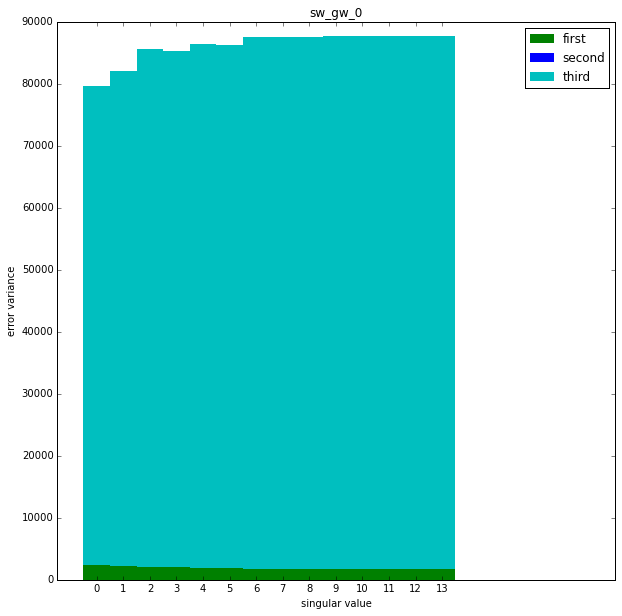

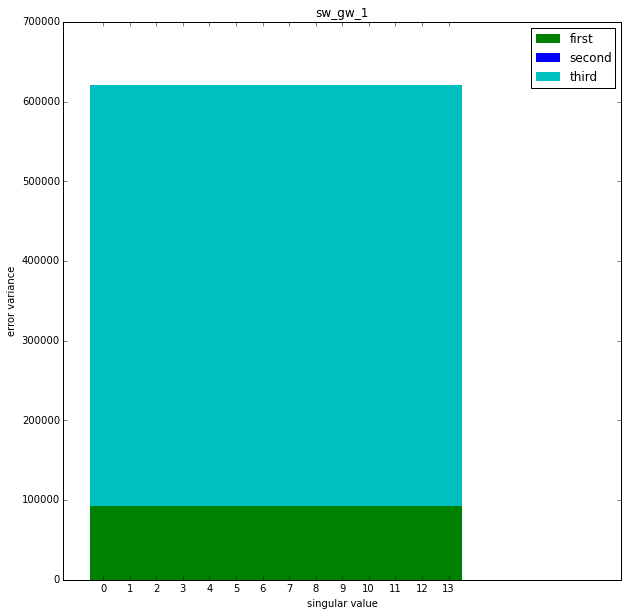

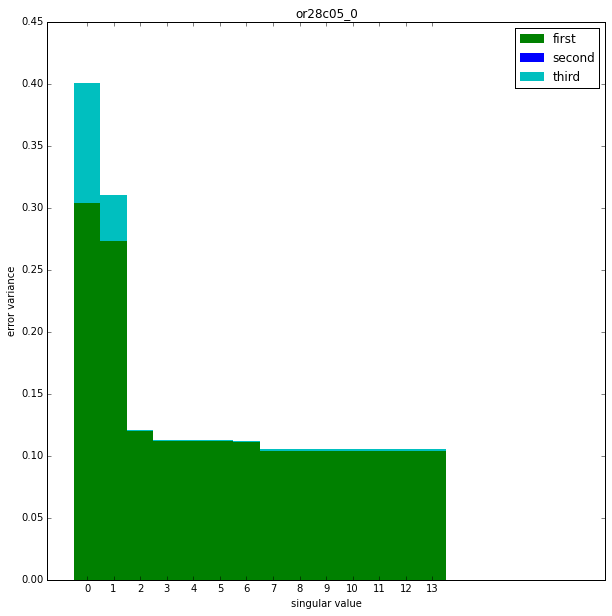

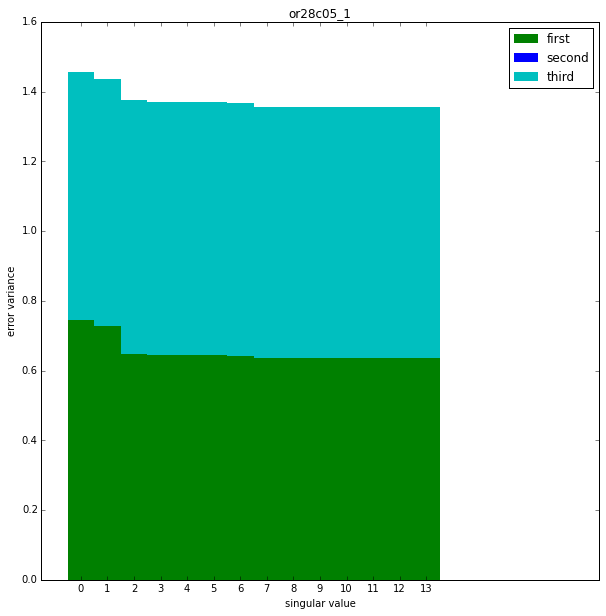

In [16]:

colors = {"first": 'g', "second": 'b', "third": 'c'}
max_idx = 19
idx = sing_vals[:max_idx]
for ipred, pred in enumerate(forecasts):
    pred = pred.lower()
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    ax.set_title(pred)
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]
    third = errvar_df[("third", pred)][:max_idx]
    ax.bar(idx, first, width=1.0, edgecolor="none", facecolor=colors["first"], label="first",bottom=0.0)
    ax.bar(idx, second, width=1.0, edgecolor="none", facecolor=colors["second"], label="second", bottom=first)
    ax.bar(idx, third, width=1.0, edgecolor="none", facecolor=colors["third"], label="third", bottom=second+first)
    ax.set_xlim(-1,max_idx+1)
    ax.set_xticks(idx+0.5)
    ax.set_xticklabels(idx)
    #if ipred == 2:
    ax.set_xlabel("singular value")
    ax.set_ylabel("error variance")
    ax.legend(loc="upper right")
plt.show()


Here we see the trade off between getting a good fit to push down the null-space (1st) term and the penalty for overfitting (the rise of the solution space (2nd) term)).  The sum of the first two terms in the "appearent" error variance (e.g. the uncertainty that standard analyses would yield) without considering the contribution from the omitted parameters.  You can verify this be checking prior uncertainty from the Schur's complement notebook against the zero singular value result using only terms 1 and 2.

We also see the added penalty for not adjusting the well flux and recharge parameters.  For the water level at the end of the calibration period forecast (``or28c05_0``), the fact the we have left parameters out doesn't matter.  However, for sw_gw_0, the situation is much worse: calibration increases the uncertainty for this forecast because the adjustable parametres are compensating for the omitted, uncertaint parameters in ways that are damanaging to the forecast.  For the forecast period sw-gw exchange, calibration doesn't help or hurt - this forecast depend entirely on null space parameter components.  

Let's check the ```errvar``` results against the results from ```schur```. This is simple with ```pyemu```, we simply  cast the ```errvar``` type to a ```schur``` type:

In [17]:
schur = la.get(astype=pyemu.Schur)
schur_prior = schur.prior_forecast
schur_post = schur.posterior_forecast
print("{0:10s} {1:>12s} {2:>12s} {3:>12s} {4:>12s}"
      .format("forecast","errvar prior","errvar min",
              "schur prior", "schur post"))
for ipred, pred in enumerate(forecasts):
    first = errvar_df[("first", pred)][:max_idx]
    second = errvar_df[("second", pred)][:max_idx]  
    min_ev = np.min(first + second)
    prior_ev = first[0] + second[0]
    prior_sh = schur_prior[pred]
    post_sh = schur_post[pred]
    print("{0:12s} {1:12.6f} {2:12.6f} {3:12.6} {4:12.6f}"
          .format(pred,prior_ev,min_ev,prior_sh,post_sh))

2015-11-27 14:01:33.545639 WARNING: LinearAnalysis.get(): astype is not None, but par_names and obs_names are None so
  ->Omitted attributes will not be propagated to new instance

forecast   errvar prior   errvar min  schur prior   schur post
sw_gw_0       2346.665821  1711.075829      2346.67  1711.075639
sw_gw_1      93125.784926 92807.404988      93125.8 92807.404858
or28c05_0        0.303632     0.104009     0.303632     0.104009
or28c05_1        0.744522     0.635596     0.744522     0.635596


We see that the prior from ```schur``` class matches the two-term ```errvar``` result at zero singular values.  We also see, as expected, the posterior from ```schur``` is slightly lower than the two-term ```errvar``` result.  This shows us that the "appearent" uncertainty in these predictions, as found through application of Bayes equation, is being under estimated because if the ill effects of the omitted parameters.